In [11]:
# Extracting tar file

#import tarfile
#file_path = 'BreaKHis_v1.tar.gz'
#try:
#    with tarfile.open(file_path, 'r:gz') as tar:
#        tar.extractall()  # Extracts to the current directory
#    print("Extraction successful!")
#except Exception as e:
#    print(f"An error occurred during extraction: {e}")


Extraction successful!


In [53]:
#!pip install matplotlib
#!pip install pytorchcv
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 212.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 79.6 MB/s eta 0:00:0000:01:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [54]:
import os
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import shutil
import zipfile
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from pytorchcv.model_provider import get_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [4]:
# base directory for the dataset
dataset_dir = os.path.join('.', 'Dataset')
classes = ['Benign', 'Malignant']

In [6]:
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('png'))]
    print(f"Class '{cls}' contains {len(image_files)} images")

Class 'Benign' contains 2480 images
Class 'Malignant' contains 5444 images


In [12]:
# average image dimensions for each class
def compute_image_stats(class_dir):
    widths, heights = [], []
    for file in os.listdir(class_dir):
        if file.lower().endswith(('png')):
            img = Image.open(os.path.join(class_dir, file))
            widths.append(img.width)
            heights.append(img.height)
    return np.mean(widths), np.mean(heights)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    mean_width, mean_height = compute_image_stats(class_dir)
    print(f"Average dimensions for class '{cls}': {mean_width:.1f} x {mean_height:.1f} pixels")

Average dimensions for class 'Benign': 700.0 x 460.0 pixels
Average dimensions for class 'Malignant': 700.0 x 459.9 pixels


# Normalization

In [15]:
# image resizing
transform_common = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [24]:

# removing file bcoz it was showing error

checkpoints_path = os.path.join('Dataset', '.ipynb_checkpoints')

if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)
    print("Removed '.ipynb_checkpoints' folder.")
else:
    print("'.ipynb_checkpoints' folder not found.")


'.ipynb_checkpoints' folder not found.


In [23]:
# Create dataset using ImageFolder 
def is_valid_file(x):
    return x.endswith(('.png')) and not x.startswith('.ipynb_checkpoints')

# Create dataset using ImageFolder
dataset_dir = './Dataset'
dataset = ImageFolder(root=dataset_dir, transform=transform_common, is_valid_file=is_valid_file)

In [25]:
# Create a DataLoader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [26]:
# Verify the pipeline by checking one batch of images
for images, labels in data_loader:
    print("Batch image shape:", images.shape)
    print("Batch labels:", labels)
    break

Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0])


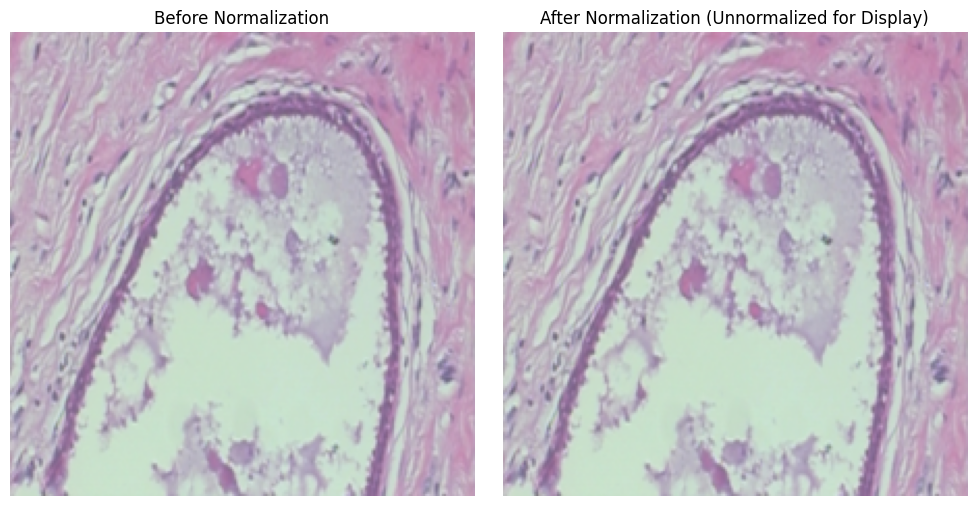

In [2]:
# Define the transforms
transform_raw = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor()           # Convert to tensor; values in [0,1]
])

transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to "unnormalize" a tensor so it can be visualized.
def unnormalize(tensor, mean, std):
    """
    Revert the normalization on a tensor.
    Assumes tensor shape is (C, H, W)
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

sample_image_path = os.path.join('Dataset', 'Benign', 'SOB_B_A-14-22549AB-100-001.png')

img = Image.open(sample_image_path).convert('RGB')

# Apply the raw (before normalization) transform
img_raw_tensor = transform_raw(img)
# Apply the normalized transform
img_norm_tensor = transform_norm(img)
# Unnormalize the normalized image for visualization
img_norm_vis = unnormalize(img_norm_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Clamp values to [0, 1] for proper display
img_norm_vis = torch.clamp(img_norm_vis, 0, 1)

# Convert tensors to numpy arrays for display (shape from C,H,W to H,W,C)
img_raw_np = np.transpose(img_raw_tensor.numpy(), (1, 2, 0))
img_norm_np = np.transpose(img_norm_vis.numpy(), (1, 2, 0))

# Plot side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_raw_np)
plt.title("Before Normalization")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_norm_np)
plt.title("After Normalization (Unnormalized for Display)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Data Augmentation

In [3]:


input_dir = './Dataset'
output_dir = './Dataset_Augmented'
classes = ['Benign', 'Malignant']


for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# augmentation transform 
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(10),         
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])


num_augmented_versions = 5


for cls in classes:
    input_class_dir = os.path.join(input_dir, cls)
    output_class_dir = os.path.join(output_dir, cls)
    
    
    for filename in os.listdir(input_class_dir):
        if filename.lower().endswith(('png')):
            img_path = os.path.join(input_class_dir, filename)
            img = Image.open(img_path).convert("RGB")
            
            for i in range(num_augmented_versions):
                aug_img = transform_aug(img)
                base_name = os.path.splitext(filename)[0]
                output_filename = f"{base_name}_aug_{i}.jpg"
                output_path = os.path.join(output_class_dir, output_filename)
                aug_img.save(output_path)
                print(f"Saved augmented image: {output_path}")


Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-007_aug_0.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-007_aug_1.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-007_aug_2.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-007_aug_3.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-007_aug_4.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-014_aug_0.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-014_aug_1.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-014_aug_2.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-014_aug_3.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-014_aug_4.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_B_A-14-29960CD-40-013_aug_0.jpg
Saved augmented image: ./Dataset_Augmented/Benign/SOB_

# Inception-v4 Model

In [ ]:
#Dataset Spliting

In [39]:
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset from the raw folder
dataset = datasets.ImageFolder(root='./Dataset', transform=transform_train)
print("Dataset loaded successfully, total samples:", len(dataset))

Dataset loaded successfully, total samples: 7930


In [40]:
dataset_size = len(dataset)               
train_size = int(0.8 * dataset_size)        # 80% for training
val_size = dataset_size - train_size        # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [41]:
#Create DataLoaders

In [42]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
# Model Building

In [45]:
model = get_model("inceptionv4", pretrained=True)
num_ftrs = model.output.fc.in_features
model.output.fc = nn.Linear(num_ftrs, 2) 
model = model.to(device)                 


In [46]:
criterion = nn.CrossEntropyLoss()       # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  

In [47]:
# Training Loop

In [48]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  

        optimizer.zero_grad()           
        outputs = model(inputs)            
        loss = criterion(outputs, labels)  
        loss.backward()                  
        optimizer.step()                 

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss

   
    epoch_loss = running_loss / train_size
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")


Epoch 1/10, Training Loss: 0.4147
Epoch 2/10, Training Loss: 0.3109
Epoch 3/10, Training Loss: 0.2611
Epoch 4/10, Training Loss: 0.2371
Epoch 5/10, Training Loss: 0.2357
Epoch 6/10, Training Loss: 0.2154
Epoch 7/10, Training Loss: 0.2087
Epoch 8/10, Training Loss: 0.2034
Epoch 9/10, Training Loss: 0.1808
Epoch 10/10, Training Loss: 0.1968


In [ ]:
# Validation Loop

In [50]:
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)             
            _, preds = torch.max(outputs, 1)       
            correct += (preds == labels).sum().item()  
            total += labels.size(0)                

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 10/10, Validation Accuracy: 94.20%


# Validation Dataset Loading

In [2]:
# zip_path = 'Dataset2.zip' 
# extract_dir = 'Dataset2'  

# os.makedirs(extract_dir, exist_ok=True)


# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f"Images extracted to {extract_dir}")



Images extracted to Dataset2


In [3]:
import os
import shutil

# Define source directory (extracted dataset) and target directories
source_dir = 'Dataset_IDC'
target_dir = 'Dataset2'
benign_dir = os.path.join(target_dir, 'Benign')      
malignant_dir = os.path.join(target_dir, 'Malignant') 


os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

def get_unique_filename(directory, filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    unique_filename = filename
    while os.path.exists(os.path.join(directory, unique_filename)):
        unique_filename = f"{base}_{counter}{ext}"
        counter += 1
    return unique_filename

for root, dirs, files in os.walk(source_dir):
    current_folder = os.path.basename(root)
    if current_folder == '0' or current_folder == '1':
        target_subdir = benign_dir if current_folder == '0' else malignant_dir
        
        for file in files:
            src_file = os.path.join(root, file)
            unique_file = get_unique_filename(target_subdir, file)
            dst_file = os.path.join(target_subdir, unique_file)
            shutil.copy(src_file, dst_file)

print("Dataset conversion completed.")


Dataset conversion completed.


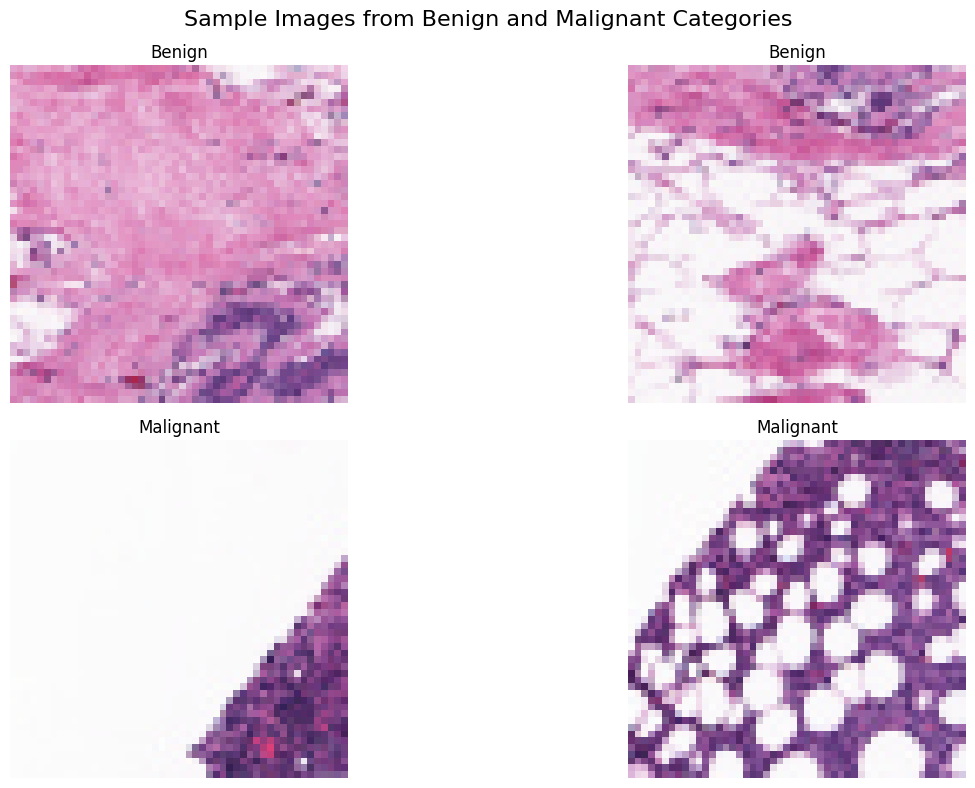

In [5]:

benign_dir = os.path.join("Dataset2", "Benign")
malignant_dir = os.path.join("Dataset2", "Malignant")

benign_images = glob.glob(os.path.join(benign_dir, '*'))
malignant_images = glob.glob(os.path.join(malignant_dir, '*'))

num_images = 2

fig, axs = plt.subplots(2, num_images, figsize=(15, 8))

for i in range(num_images):
    if i < len(benign_images):
        img = Image.open(benign_images[i])
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        axs[0, i].set_title("Benign")
    else:
        axs[0, i].axis('off')

for i in range(num_images):
    if i < len(malignant_images):
        img = Image.open(malignant_images[i])
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        axs[1, i].set_title("Malignant")
    else:
        axs[1, i].axis('off')

plt.suptitle("Sample Images from Benign and Malignant Categories", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:


# Validation transform: resizing + normalization (no augmentation)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset using ImageFolder
val_dataset = datasets.ImageFolder(root='./Dataset2', 
                                   transform=transform_val)

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Quick check
for images, labels in val_loader:
    print("Batch image shape:", images.shape)
    print("Batch labels:", labels)
    break


Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])


# External Testing and Performance Evaluation

# Inception-v4 External Dataset Testing

In [55]:
#  transformation for the external test set 
transform_test = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [56]:

test_dataset = datasets.ImageFolder(root='./Dataset2', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
# Evaluate the model on the external test set
model.eval()  
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [59]:
# Calculate accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean()
print(f"External Test Accuracy: {accuracy * 100:.2f}%")

External Test Accuracy: 34.73%


In [60]:
# Generate a confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Confusion Matrix:
[[ 72920 324556]
 [ 37744 119828]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.66      0.18      0.29    397476
   Malignant       0.27      0.76      0.40    157572

    accuracy                           0.35    555048
   macro avg       0.46      0.47      0.34    555048
weighted avg       0.55      0.35      0.32    555048



In [61]:
# Optionally, plot the ROC curve for one of the classes (if binary classification)

all_probs = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1
        all_probs.extend(probs.cpu().numpy())
all_probs = np.array(all_probs)

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

KeyboardInterrupt: 

In [63]:
print(train_size)

6344


In [1]:
nvidia-smi


NameError: name 'nvidia' is not defined